## Вторая и третья часть задания: извлечение feature vector и применение градиентного бустинга

### Начнем с извлечения feature vector

Загрузка библиотек:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
# import torch.optim as optim
#import os
# import torch.nn.functional as F
import matplotlib.pyplot as plt
# from collections import defaultdict # to check distribution by classes
# from sklearn.metrics import precision_recall_fscore_support # to calculate F1 score
# from sklearn.model_selection import StratifiedShuffleSplit # to split images to train, val, and test
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем лучший стейт обученной модели 

In [18]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_dataset = torchvision.datasets.ImageFolder('images', transform=transform)
image_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=32, shuffle=False)

model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(512, len(image_dataset.classes))
model.load_state_dict(torch.load('best_model_42.pt'))
image_classes = image_dataset.classes


Заменяем последний полносвязный уровень на единицы, чтобы извлечь признаки предпоследнего уровня для каждого изображения

In [3]:
model.fc_backup = model.fc
# model.fc = nn.Sequential()
model.fc = nn.Identity()

In [4]:
model.eval()
all_features = []
with torch.no_grad():
    for inputs, labels in image_dataloader:
        outputs = model(inputs)
        features = outputs
        all_features.append(features)
all_features = torch.cat(all_features, dim=0)

In [5]:
print(all_features)
print(all_features.size())
labels = np.concatenate([batch[1].numpy() for batch in image_dataloader])


tensor([[0.7073, 0.0000, 2.4070,  ..., 1.2379, 0.0000, 3.9121],
        [5.1334, 3.6068, 3.5940,  ..., 2.3709, 0.0000, 0.4671],
        [1.2300, 0.0000, 0.0000,  ..., 0.5910, 0.0000, 0.9238],
        ...,
        [0.0000, 0.0000, 0.8527,  ..., 0.3733, 0.0000, 0.4820],
        [0.0000, 0.1503, 2.7760,  ..., 0.0000, 0.0000, 1.9435],
        [0.0000, 3.4596, 1.7681,  ..., 1.0148, 0.3906, 0.0000]])
torch.Size([1422, 512])


Полученная матрица (тензор) *feature vector* имеет размерность количество изображений (1422) * количество нейронов (512) на последнем уровне.

### Попробуем сделать кластеризацию различными алгоритмами

Сначала попробуем понизить размерность: используем PCA. 

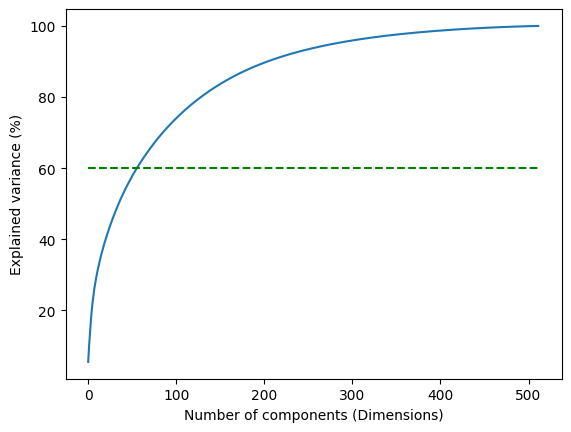

In [6]:
# используем StandardScaler для шкалирования наших данных
sc = StandardScaler()
X_scaled = sc.fit_transform(all_features)

# Apply PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
# print("Eigenvalues:")
# print(pca.explained_variance_)
# print()

# Get explained variances
# print("Variances (Percentage):")
# print(pca.explained_variance_ratio_ * 100)
# print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.hlines(y = 60, xmin = 0, xmax = 512, colors = 'g', linestyles = '--')
plt.show()

Можно увидеть, что первые главные компоненты объясняют достаточно мало дисперсии. Это значит, что признаки получились мало коррелированы между собой.
Попробуем сделать кластеризацию методом к-средних на исходной матрице, количество кластеров выбираем 8, как и число классов изображения:

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(all_features)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

from sklearn.metrics import adjusted_rand_score

labels == labels_kmeans
ari = adjusted_rand_score(labels, labels_kmeans)
print("Adjusted Rand Index: {:.4f}".format(ari))

C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.3618


Для оценки точности используем функцию `adjusted_rand_score`, которая сама определяет наиболее вероятный лейбл кластера. Точность кластеризации получилась не очень высокая. Для визуализации и отрисовки лейблов используем UMAP.

In [8]:
import umap.umap_ as umap
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.3,
                      metric='correlation').fit_transform(all_features)

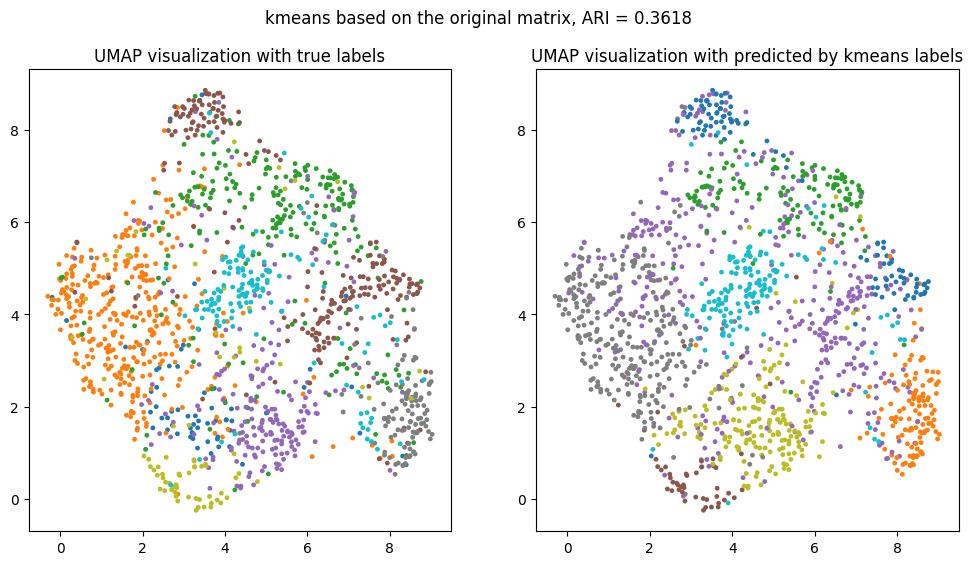

In [9]:
# Plot the UMAP visualization with true labels

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=6)
axes[0].set_title('UMAP visualization with true labels')
# axes[0].colorbar()
# Plot the UMAP visualization with predicted labels
axes[1].scatter(embedding[:, 0], embedding[:, 1], c=labels_kmeans, cmap='tab10', s=6)
axes[1].set_title('UMAP visualization with predicted by kmeans labels')
# axes[1].colorbar()
# plt.colorbar(ax=axes)
fig.suptitle('k-means based on the original matrix, ARI = {:.4f}'.format(ari))

plt.show()

# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s = 6)
# plt.colorbar()
# plt.title('UMAP visualization with true labels')
# plt.show()

# # Plot the UMAP visualization with predicted labels
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_kmeans, cmap='tab10', s = 6)
# plt.colorbar()
# plt.title('UMAP visualization with predicted labels')
# plt.show()

Попробуем использовать алгоритм к-средних на матрице из первых 100 главных компонент

C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 4 1 ... 5 5 3]
Adjusted Rand Index: 0.3365


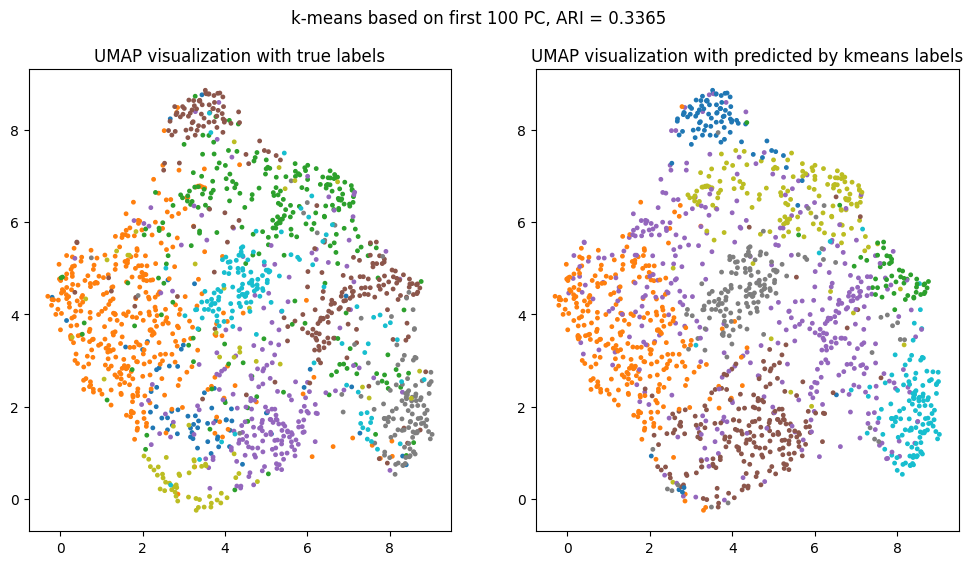

In [10]:
# from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca_data = pca.fit_transform(all_features)

# Perform k-means clustering on the PCA components
kmeans_pca = KMeans(n_clusters=8, random_state=42)
kmeans_pca.fit(pca_data)

# Print the cluster labels assigned to each data point
print(kmeans_pca.labels_)

ari_pca = adjusted_rand_score(labels, kmeans_pca.labels_)
print("Adjusted Rand Index: {:.4f}".format(ari_pca))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=6)
axes[0].set_title('UMAP visualization with true labels')
# axes[0].colorbar()
# Plot the UMAP visualization with predicted labels
axes[1].scatter(embedding[:, 0], embedding[:, 1], c=kmeans_pca.labels_, cmap='tab10', s=6)
axes[1].set_title('UMAP visualization with predicted by kmeans labels')
fig.suptitle('k-means based on first 100 PC, ARI = {:.4f}'.format(ari_pca))

# axes[1].colorbar()
# plt.colorbar(ax=axes)
plt.show()


Точность кластеризации ухудшилась после использования главных компонент, возможно потому что исходные переменные не были сильно скоррелированы друг с другом. Попробуем использовать иерархическую кластеризацию

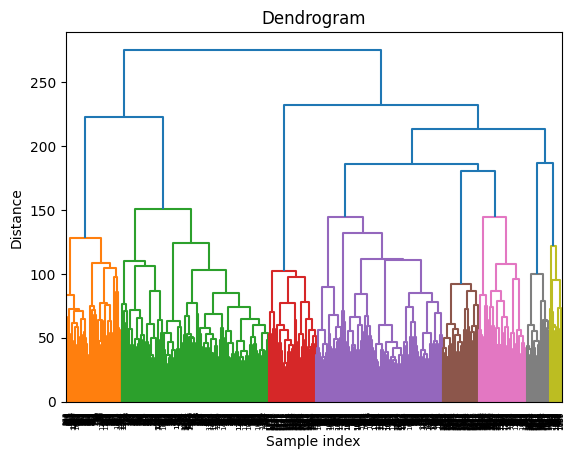

Adjusted Rand score: 0.3082697340320522


In [43]:
# import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical clustering
Z = linkage(all_features, method='ward')

# Cut the dendrogram to 8 groups
labels_hier = fcluster(Z, 8, criterion='maxclust')
color_threshold = Z[-7, 2]
# Plot the dendrogram to visualize the hierarchy

dendrogram(Z, color_threshold=color_threshold)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


# Compare the resulting labels with the true labels
score = adjusted_rand_score(labels, labels_hier)
print('Adjusted Rand score:', score)

Теперь попробуем использовать метод k-ближайших соседей. Загрузим те же самые индексы тренировочного датасета и тестового + валидационного, чтобы избежать утечки данных. 

In [13]:
train_index = np.load('train_index.npy')
train_index
test_index = np.load('test_index.npy')
print(test_index)
X_train = all_features[train_index]
X_test = all_features[test_index]
y_train = labels[train_index]
y_test = labels[test_index]

[ 640  295 1277  734  897 1304   79  955  908  116  252  660 1187  716
 1382 1017 1147 1121  663 1077 1181  592  822  990  353  927 1262  430
  530 1311  391  778  515 1172  396 1397 1162 1190 1079   35 1018 1049
 1010  967  291  618  503  826 1282  277 1416 1076 1324  722 1066 1111
 1313 1275  605  375  771  357  266  192  747  165  590  810  619  307
  670  934  553    1  558  675  936  788  981  784  280 1207  656  325
  567  916  344  180  451  198 1150  940  880   92  966  607   97 1280
  697  621  347 1153   42  458   10  615  893  931  498  947    7  193
 1045 1056  668 1084 1003  860  172  100 1052  878  657  235  145  704
  118  653 1320  600  951  129 1071  410 1240 1235 1288  112  885  316
 1323 1059 1182 1194 1388 1095  439  383 1296  673 1264  652  236 1136
 1087  650  243   52 1041 1270 1286  939  109  509  323  914  633 1417
  424 1168  701  958  389  278  841  126  328  699  576  324 1409   57
  305  106  200  814  876  494 1373 1242  993  195 1384   93 1126 1244
 1009 

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=66)
# k = 16  # сработало хорошо
k = 17
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

acc = np.mean(y_pred == y_test)
print("Classification accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.33      0.11      0.16        19
           1       0.57      0.95      0.71       110
           2       0.55      0.64      0.59        72
           3       0.72      0.30      0.42        61
           4       0.70      0.68      0.69        65
           5       0.59      0.74      0.66        35
           6       0.80      0.17      0.29        23
           7       0.83      0.36      0.50        42

    accuracy                           0.61       427
   macro avg       0.64      0.49      0.50       427
weighted avg       0.64      0.61      0.57       427

Classification accuracy: 60.66%


Метод k-ближайших соседей отработал лучше, чем k-means, поэтому попробуем визуализировать картинки с соответствующим лейблом. По очереди отрисуем картинки, соответствующие предсказанным лейблам.

In [31]:
def show_images(indices, nrow=4,ncol=4, title = ''):
    images = [image_dataset[idx][0] for idx in indices]
    curr_labels = labels[indices]
    curr_labels = (np.take(image_classes, curr_labels))
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(21, 12))
#     plt.title('title')

# iterate over the subplots and plot the images and labels
    for i, ax in enumerate(axs.flat):
        # plot the image
        imgs = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        imgs = std * imgs + mean
        imgs = np.clip(imgs, 0, 1)
        ax.imshow(imgs)
        ax.set_title(str(curr_labels[i]))
        ax.axis("off")
    fig.suptitle(title, fontsize=18)
    plt.show()

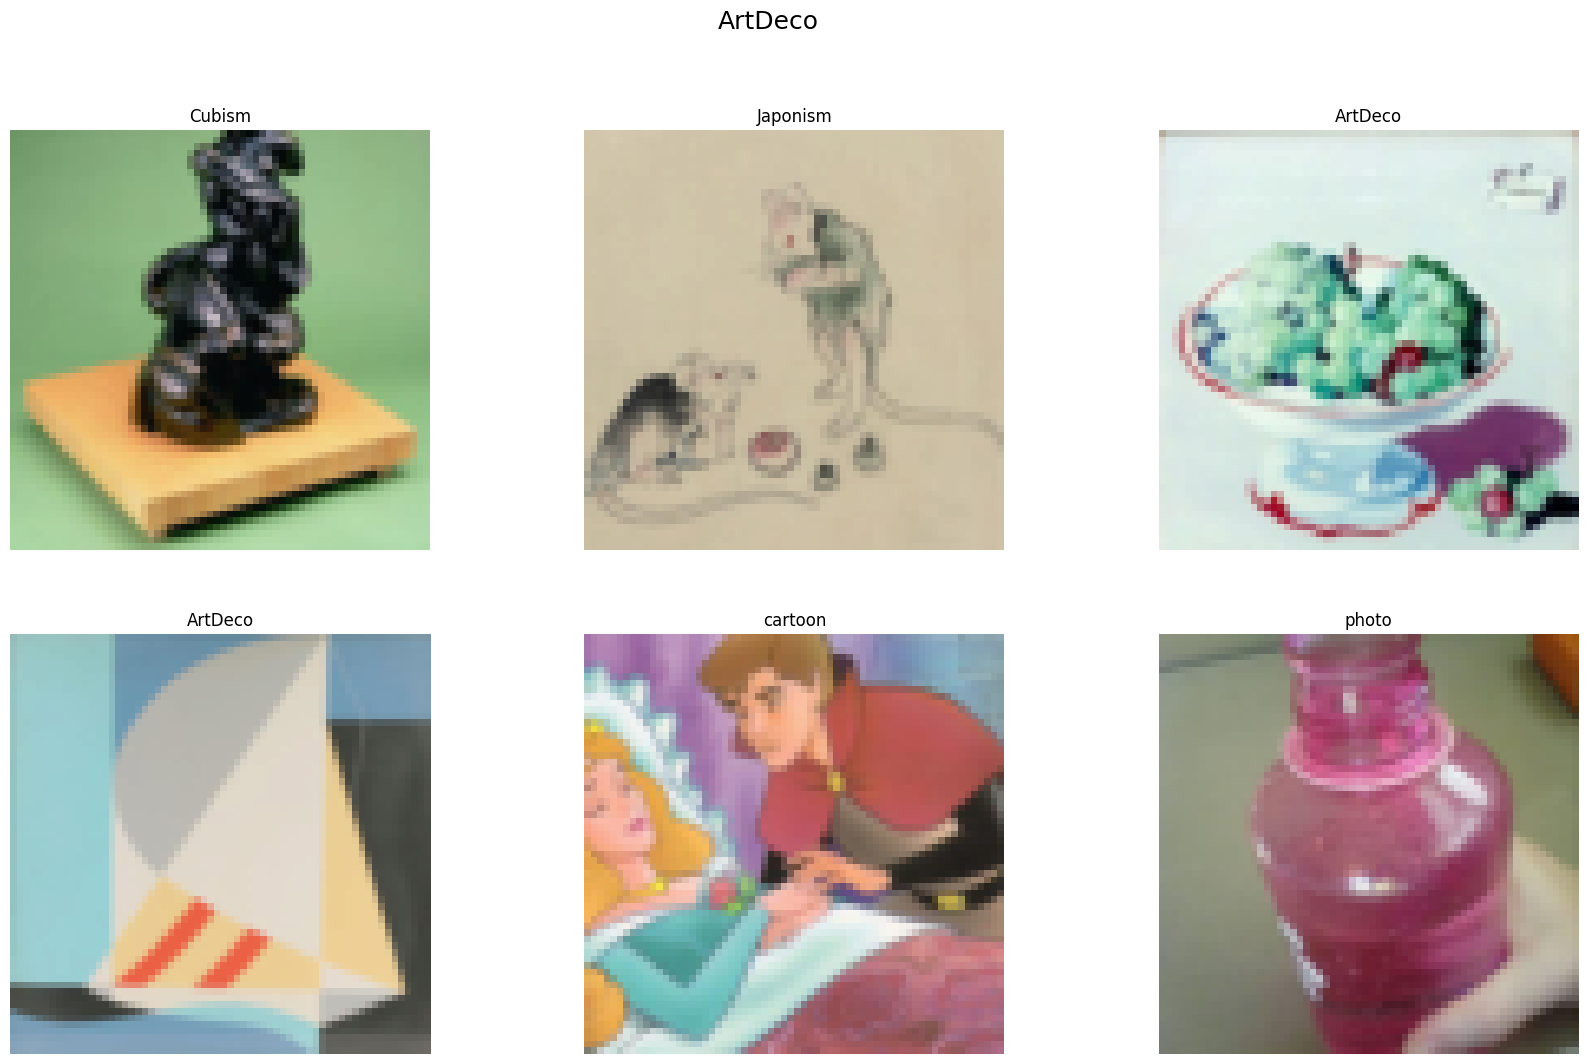

In [33]:
show_images(test_index[y_pred == 0], 2, 3, image_classes[0])

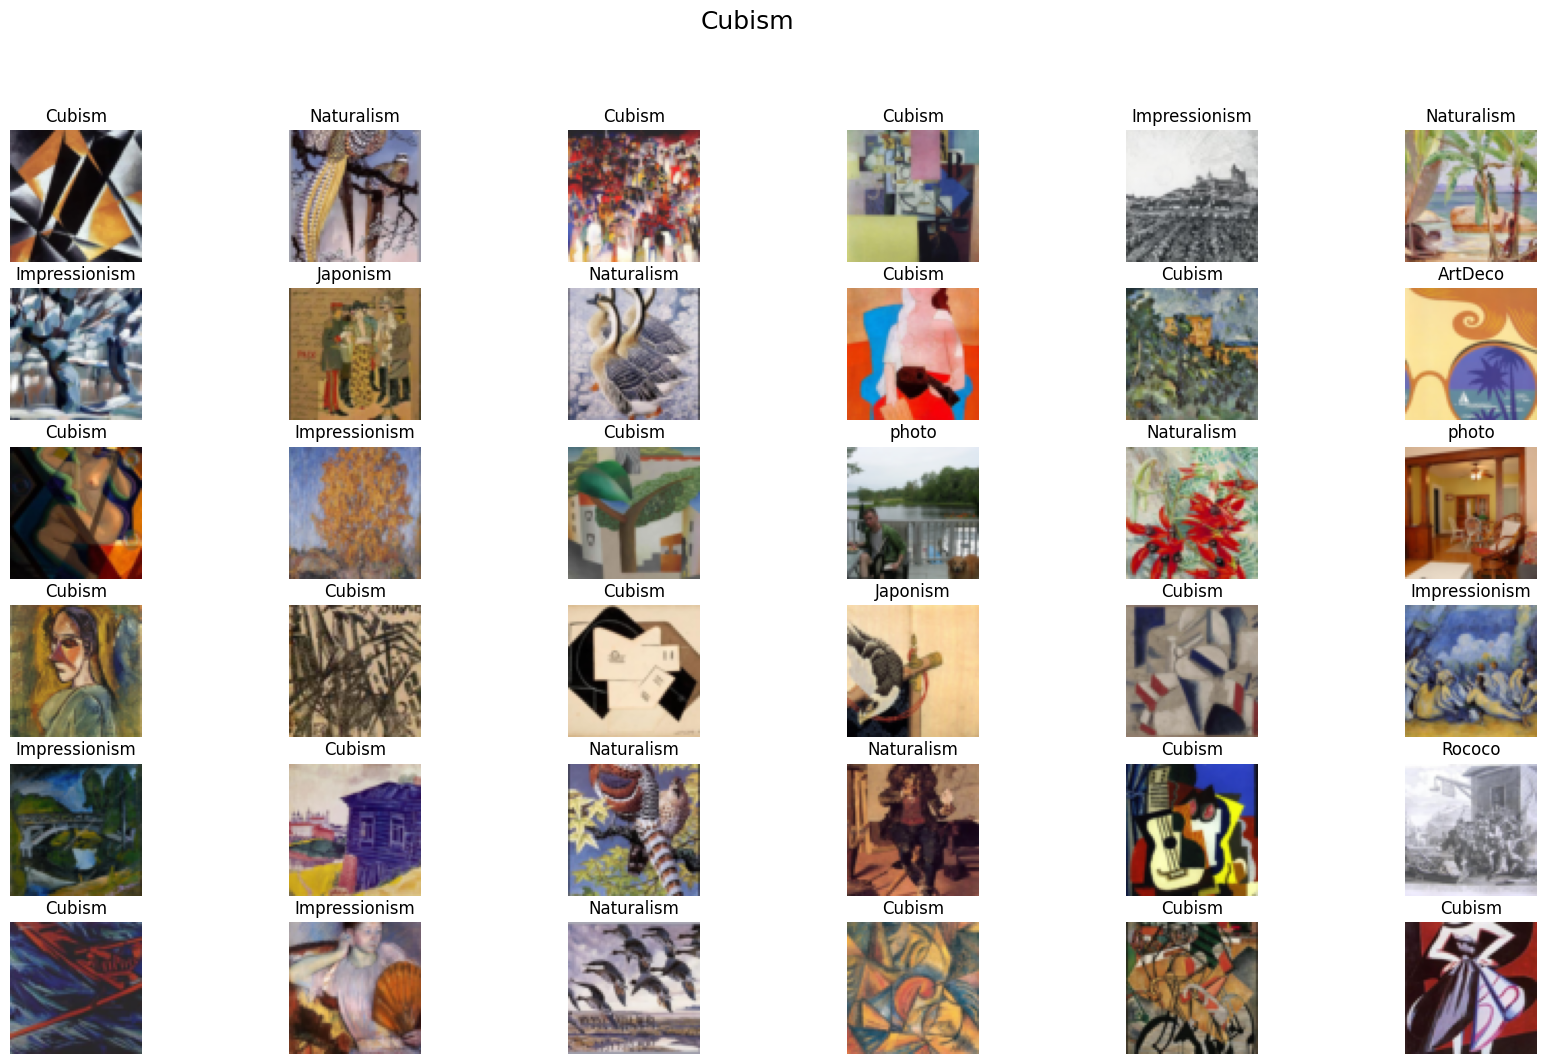

In [34]:
# plt.title('Cubism')
show_images(test_index[y_pred == 1], 6, 6, image_classes[1])
# plt.show()

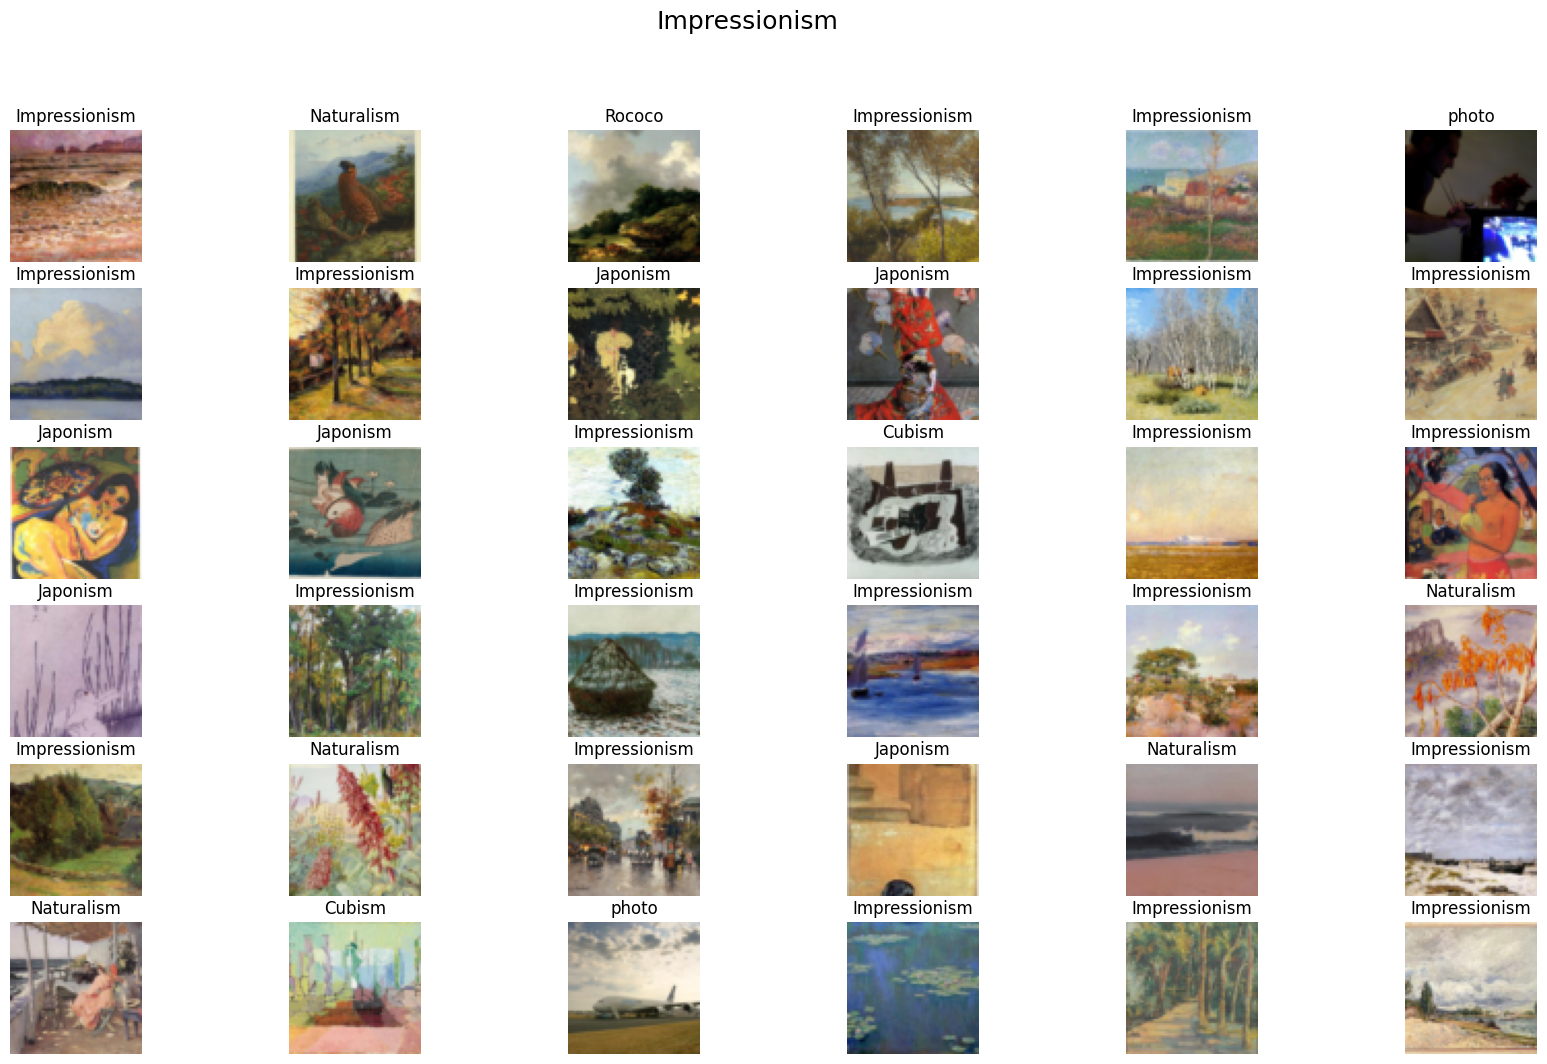

In [35]:
show_images(test_index[y_pred == 2], 6, 6, image_classes[2])


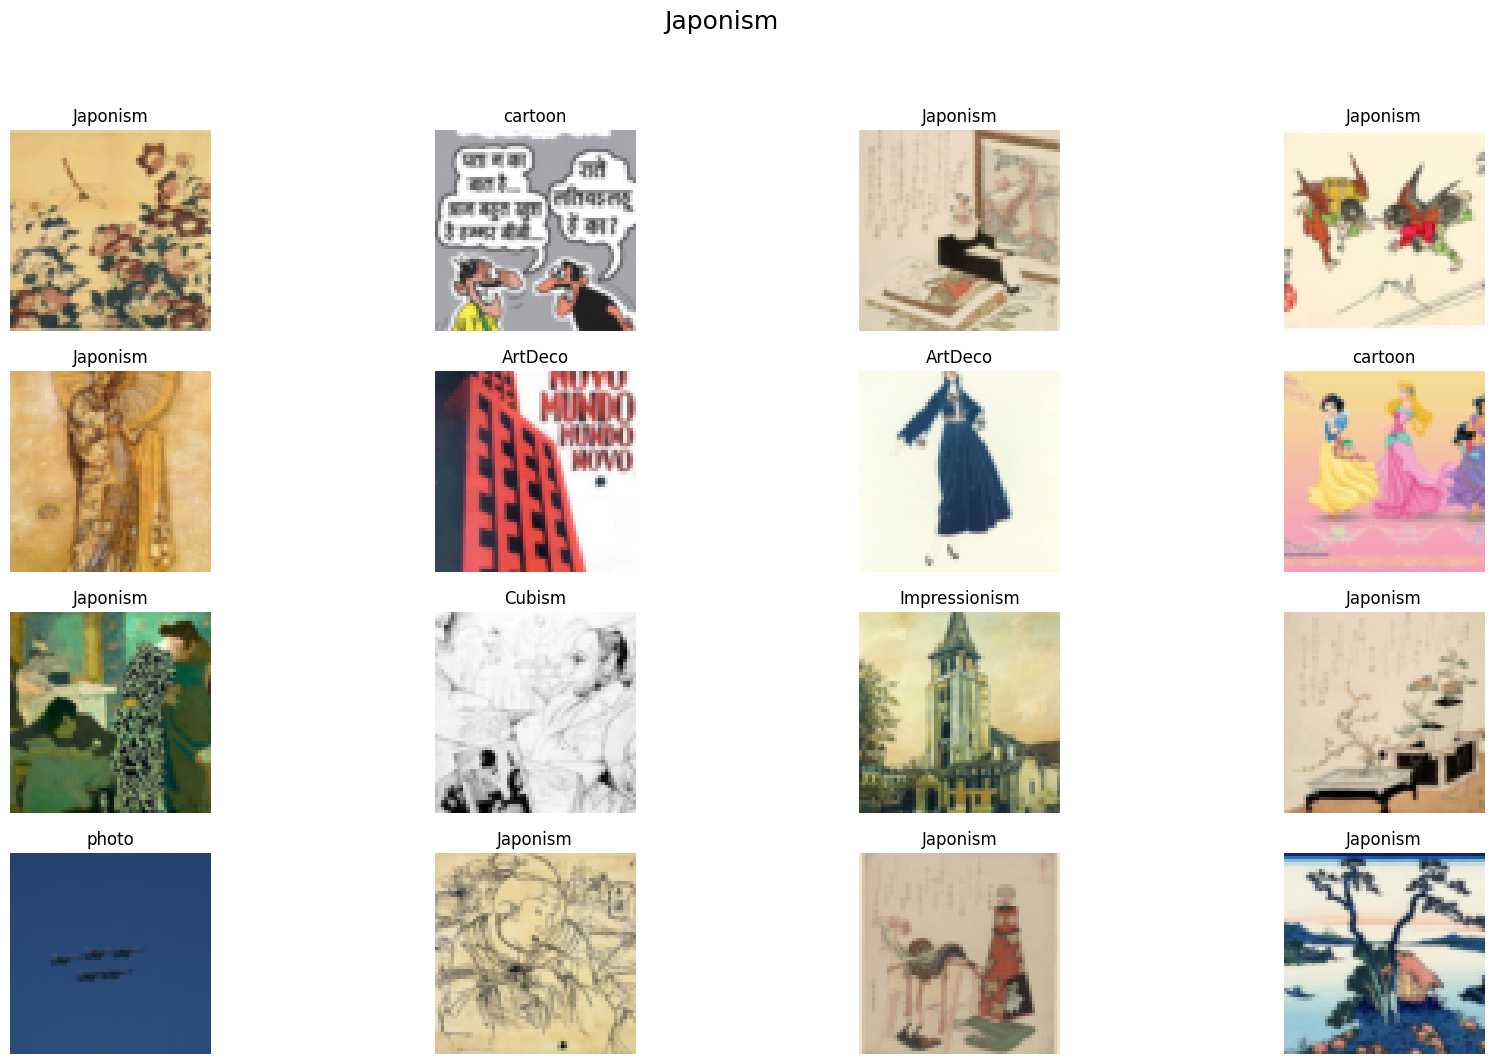

In [36]:
show_images(test_index[y_pred == 3], 4, 4, image_classes[3])

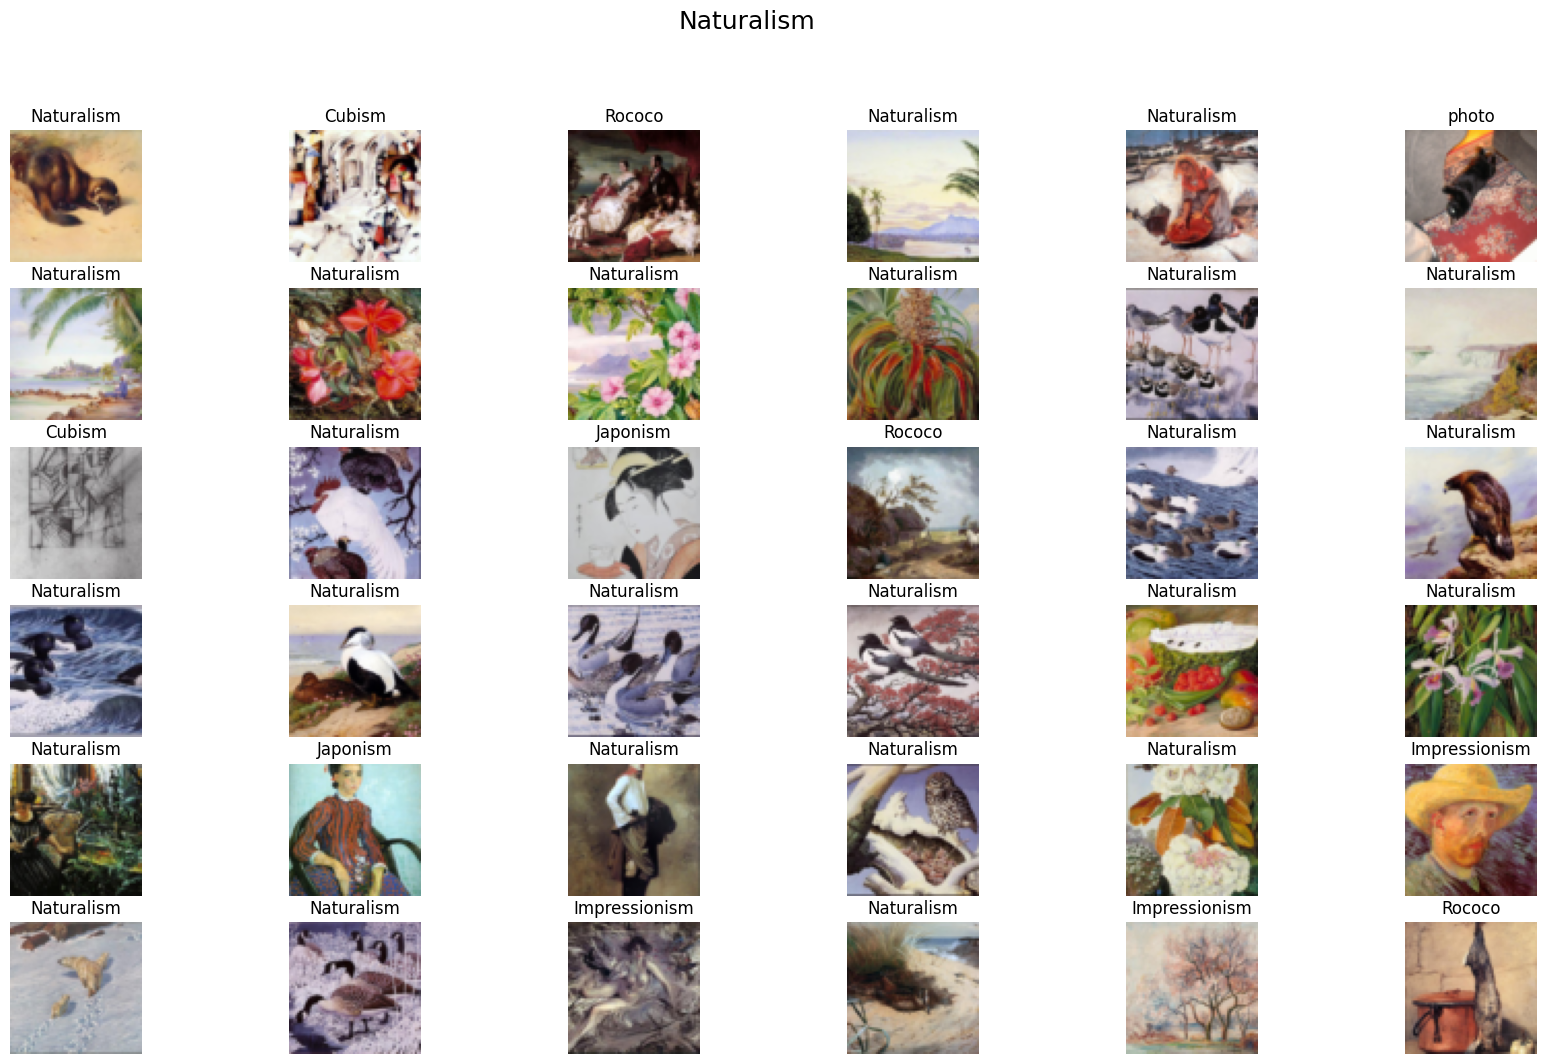

In [44]:
show_images(test_index[y_pred == 4], 6, 6, image_classes[4])


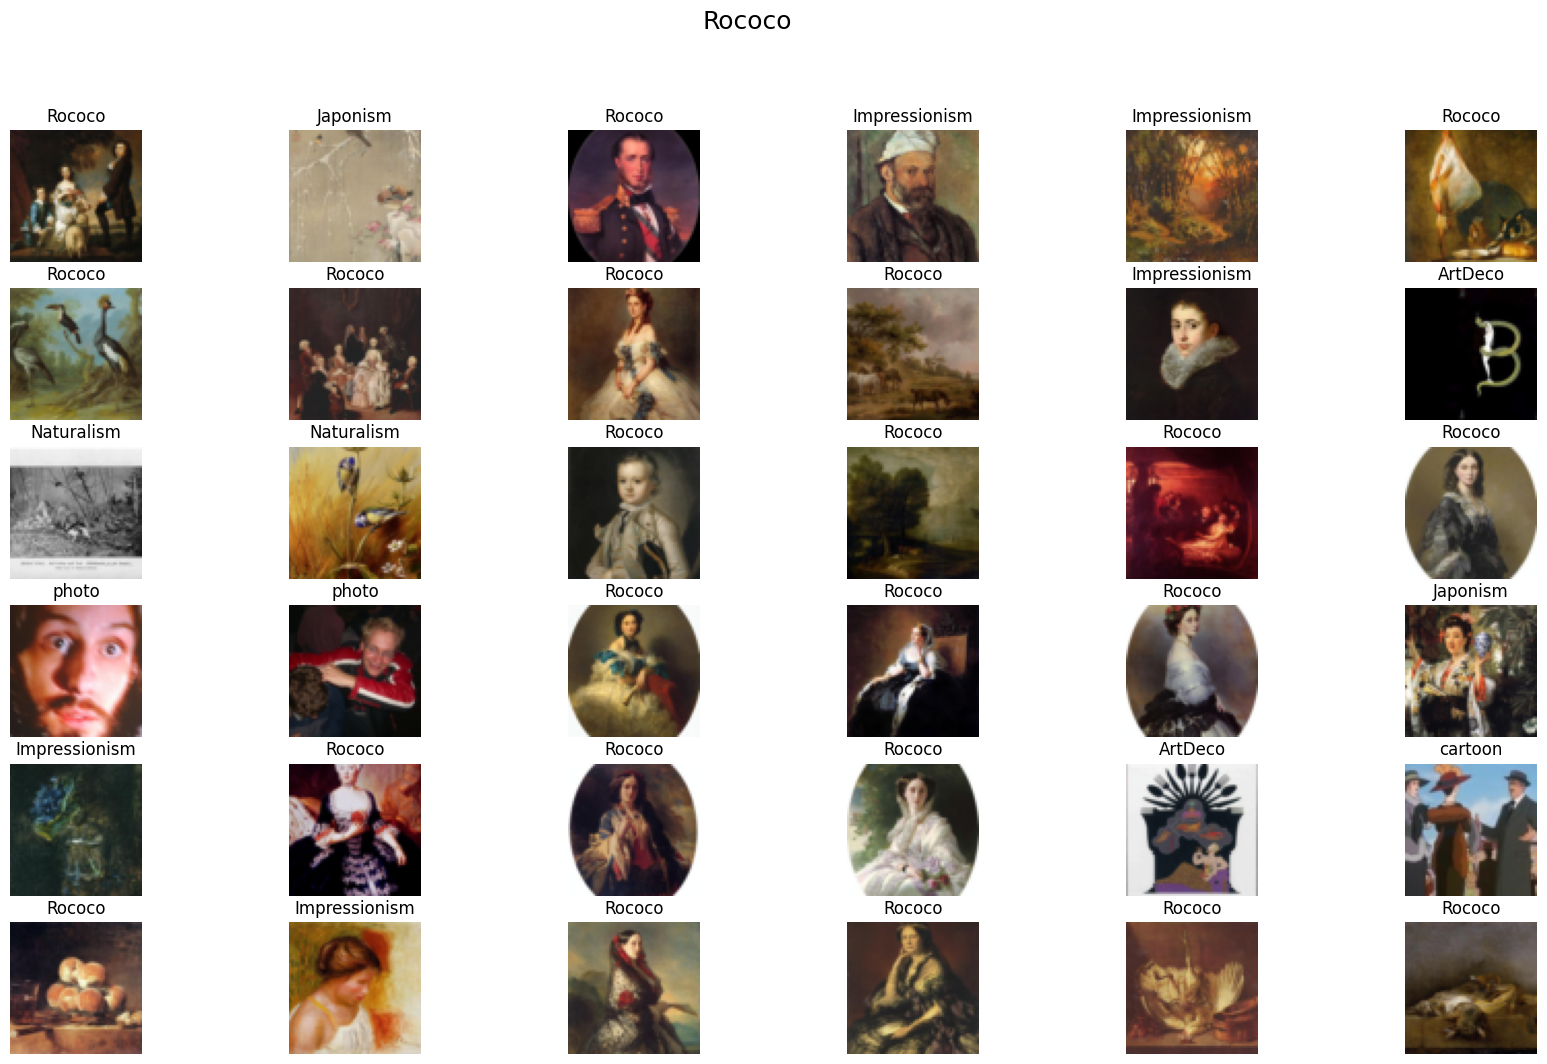

In [45]:
show_images(test_index[y_pred == 5], 6, 6, image_classes[5])


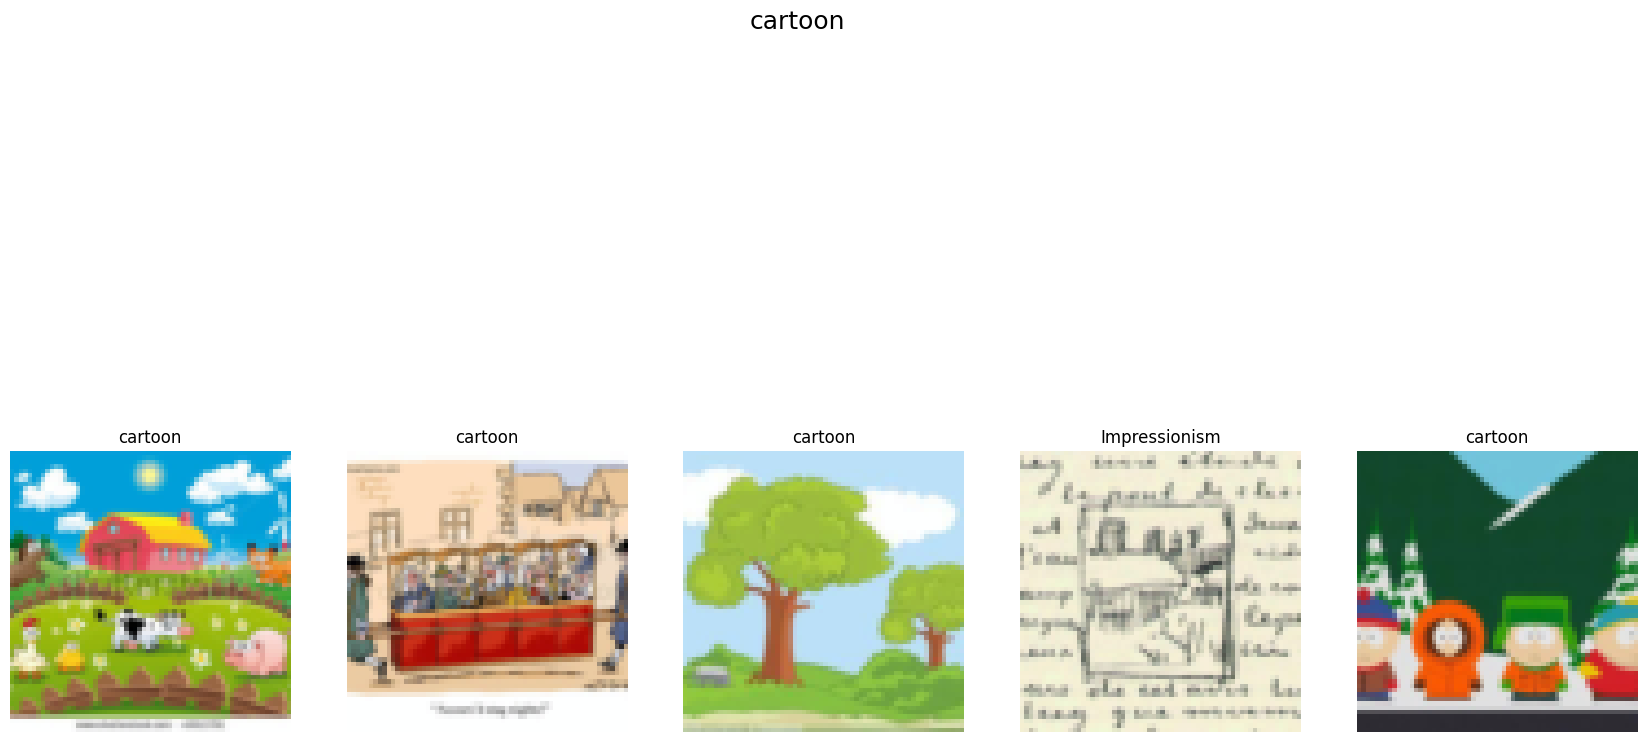

In [46]:
show_images(test_index[y_pred == 6], 1, 5, image_classes[6])


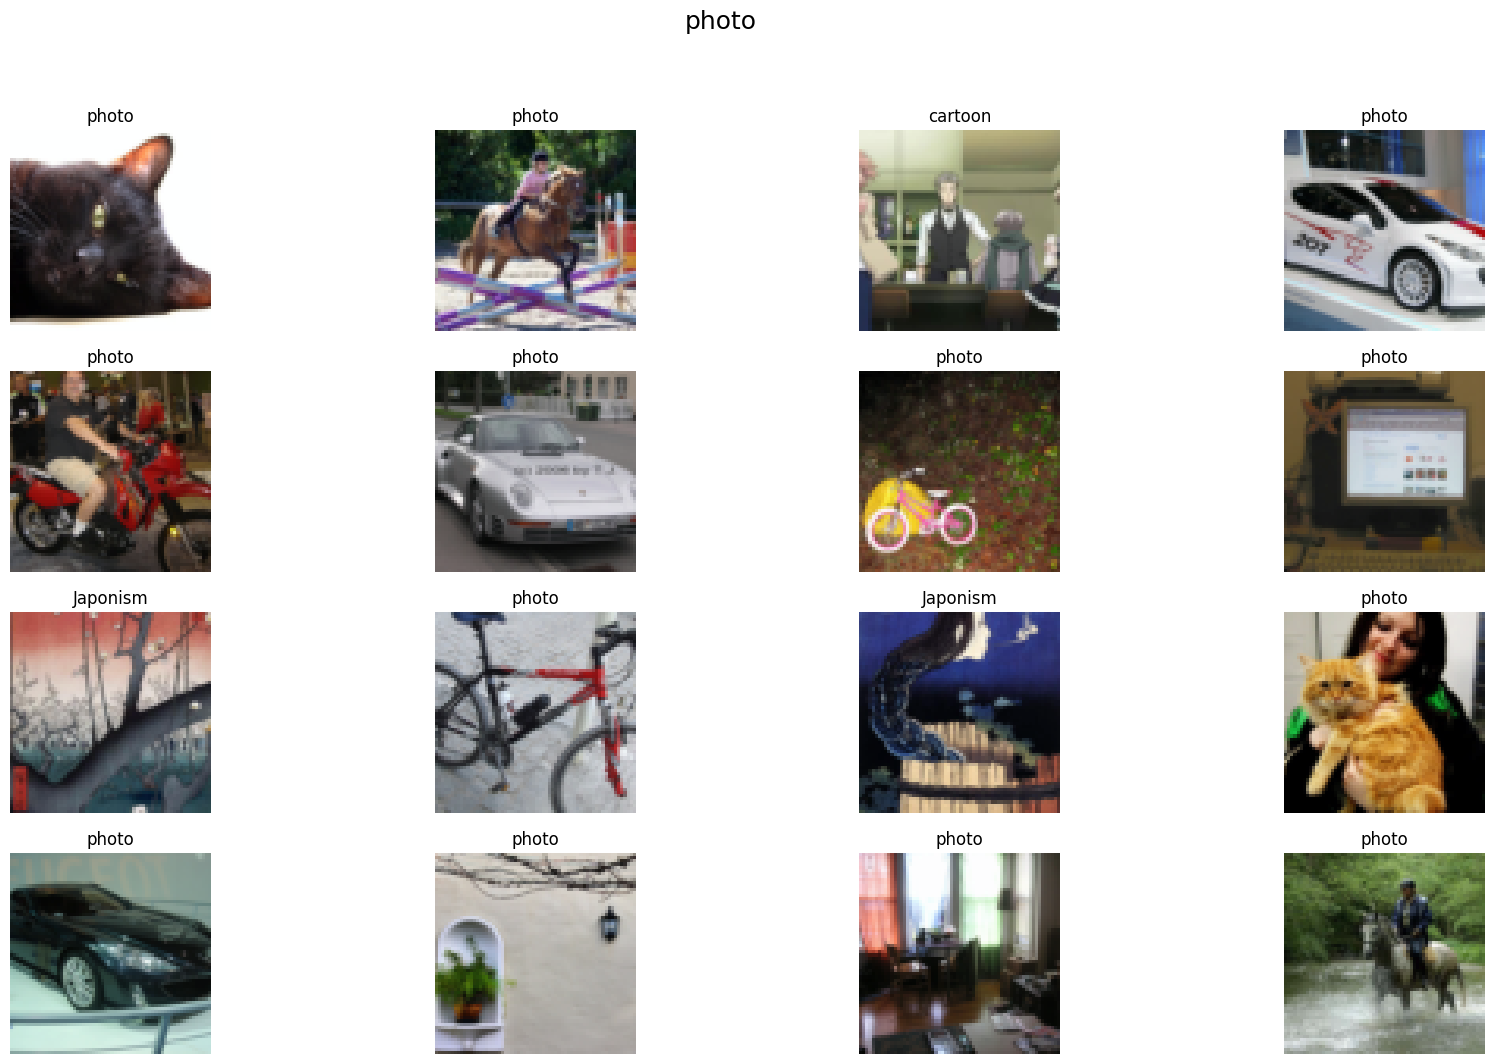

In [47]:
show_images(test_index[y_pred == 7], 4, 4, image_classes[7])


Можно заметить, что извлеченные изображения достаточно контрастные

### Третья часть задания: выполняем градиентный бустинг на извлеченные фичи

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score

# Create a gradient boosting classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the classifier on the training set
gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}')

Confusion Matrix:
[[ 8  3  0  7  0  1  0  0]
 [ 1 95  5  4  1  0  0  4]
 [ 0  9 48  4  6  2  2  1]
 [ 1 13  8 33  1  1  2  2]
 [ 0  8  8  3 44  1  0  1]
 [ 0  1  4  1  6 23  0  0]
 [ 1  4  4  5  2  0  5  2]
 [ 1  5  7  3  6  1  2 17]]
Accuracy: 0.639344262295082


In [51]:
print(f1)
print(cm)

0.627498348794802
[[ 8  3  0  7  0  1  0  0]
 [ 1 95  5  4  1  0  0  4]
 [ 0  9 48  4  6  2  2  1]
 [ 1 13  8 33  1  1  2  2]
 [ 0  8  8  3 44  1  0  1]
 [ 0  1  4  1  6 23  0  0]
 [ 1  4  4  5  2  0  5  2]
 [ 1  5  7  3  6  1  2 17]]


Точность и F1-score алгоритма градиентного бустинга почти такая же чем у нейронной сети

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the confusion matrix
confusion_matrix_xgb = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score: {f1:.3f}')

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

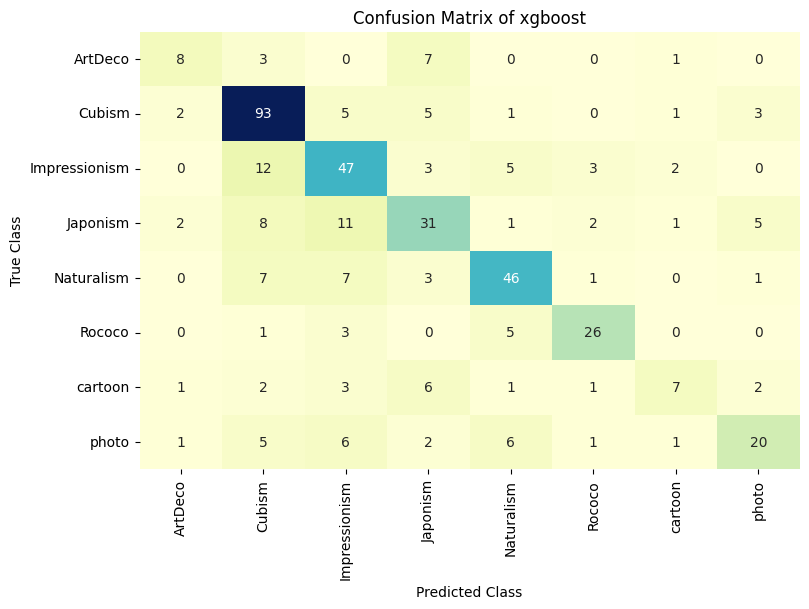

In [61]:
dataframe = pd.DataFrame(confusion_matrix_xgb, index=image_classes, columns=image_classes)
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix of xgboost"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()